In [4]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
import time,random,datetime
from scipy import sparse

import sys
sys.path.append('/home/cl2292/project/SCA1_snRNAseq/Human/')
import data as scnddata

# for this script
from scipy.stats import zscore

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1#0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [5]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Human/results_20230402/'
pdfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/processed/'
sc.settings.figdir = pfp

In [6]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='230502_human_ctype.h5ad' # for full, can maybe get away with ~300G
    %memit adata = sc.read_h5ad(os.path.join(pdfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))

peak memory: 22700.27 MiB, increment: 11210.93 MiB
loaded @230512.12:05:25
took 15.47-s to load data


In [7]:
adata = adata[adata.obs['genotype']=='Ctrl', :]

In [8]:
##Original - use for UMAP

cmap_sub4={'GC': '#FAC18A',
            'UBC': '#BA61BA',
            'PC': '#EE5264',
            'MLI1': '#F9EBAE',
            'MLI2': '#88BB92',
            'GoC': '#46A928',
            'AS': '#F9AEAE',
            'BG': '#AEB7F9',
            'OPC': '#F1815F',
            'OL': '#75A3B7',
            'MG': '#AC5861',
            'PER': '#2D284B',
            'END': '#1C67EE'}
cmap_genotype={'Ctrl':'#010101',
               'SCA1':'#ffd478'}

adata.uns['sub4_colors']=np.array(list(cmap_sub4.values()),dtype=object)
adata.obs['sub4'].cat.reorder_categories(new_categories=list(cmap_sub4.keys()),
                                         inplace=True,ordered=True)

Trying to set attribute `._uns` of view, copying.


In [10]:
interactors = []
with open(os.path.join(pfp,'ataxin-1 interactors human.csv')) as f:
    for line in f:
        gene = line.rstrip()
       # gene = gene[0] + gene[1:].lower()
        interactors.append(gene)
f.close()

In [11]:
retained_interactors = [i for i in interactors if i in adata.var.index.to_list()]
missing_interactors = [i for i in interactors if i not in adata.var.index.to_list()]
print('These interactors were not in the data:')
for i in range(0, len(missing_interactors) - 4, 4):
    print('  {}, {}, {}, {}, '.format(missing_interactors[i], missing_interactors[i+1], missing_interactors[i+2], missing_interactors[i+3]))

# create dataframe
X = pd.DataFrame({'ctype':adata.obs['sub4'],
                  'gtype':adata.obs['genotype']})

y = adata[:, retained_interactors].X
if sparse.issparse(y):
    y = y.todense()

x = pd.DataFrame(np.asarray(y),
                 columns=adata[:, retained_interactors].var_names,
                 index=adata.obs.index)

X = pd.merge(X,x, left_index=True,right_index=True)
del x

These interactors were not in the data:
  C2orf27B, FAM21C, FAM46A, FAM46B, 
  HYPM, KIAA1429, LOC401442, MAGEB18, 


In [12]:
x = X
x = x.set_index(['ctype','gtype'])
x[x.columns] = zscore(x,axis=0)
x = x.reset_index()
x = x.groupby(['ctype','gtype']).mean()
x = x.reset_index()
# x = x.set_index(['/ctype','gtype'])
x['ctype_colors'] = x['ctype'].map(cmap_sub4)
x['gtype_colors'] = x['gtype'].map(cmap_genotype)

x.to_csv('/home/cl2292/project/SCA1_snRNAseq/Human/results_20230402/ATXN1_interactor_z_score_by_ctype_CTRL.csv')

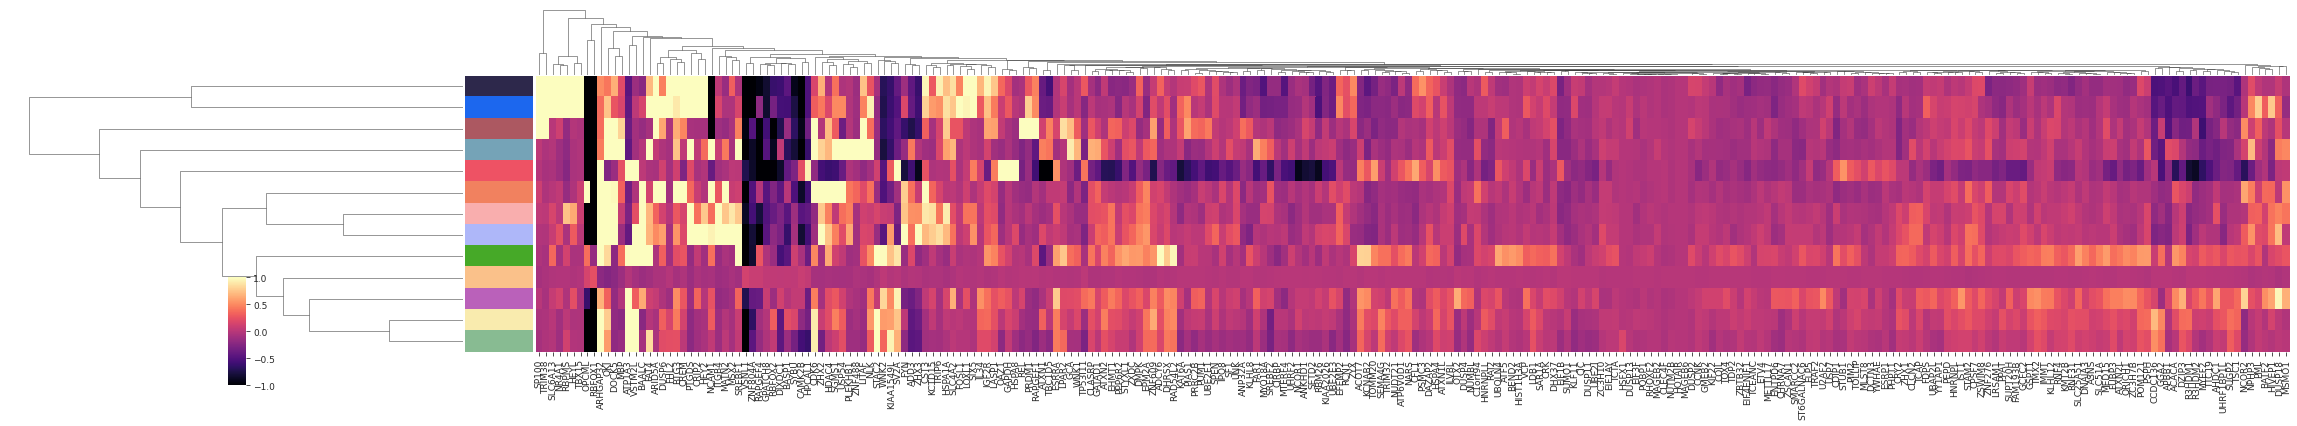

In [13]:
# plot

#x = x.drop(columns=['HOTAIR','MAGEB2'])
x_condition = x.loc[x['gtype']=='Ctrl']
cols = [i for i in x.columns if i not in ['ctype','gtype','gtype_colors','ctype_colors']]
p = sns.clustermap(x_condition[cols], 
                   cmap='magma',
                   col_cluster=True,
                   row_cluster=True,
                   row_colors=[x_condition['ctype_colors']],
                   xticklabels=True,
                   yticklabels=False,
                   vmin=-1,vmax=1,
                   figsize=(32,6))
p.cax.set_position([0.1, 0.1, .008, .25])
p.savefig(os.path.join(pfp,'ATXN1_interactor_z_score_by_ctype_CTRL_heatmap.pdf'),bbox_inches='tight')

In [14]:
genes = ['ATXN1','ATXN1L','CIC','RORA','KAT5','GFI1','NCOR2','SP1','U2AF2','RBM17','ANP32A','UBE2E1', 'UBQLN4', 'USP7', 'NLK', 'AKT1', 'PRKACA', 'RPS6KA5',
         'PAK1', 'YWHAB', 'YWHAE', 'YWHAG', 'YWHAH', 'YWHAQ', 'YWHAZ']

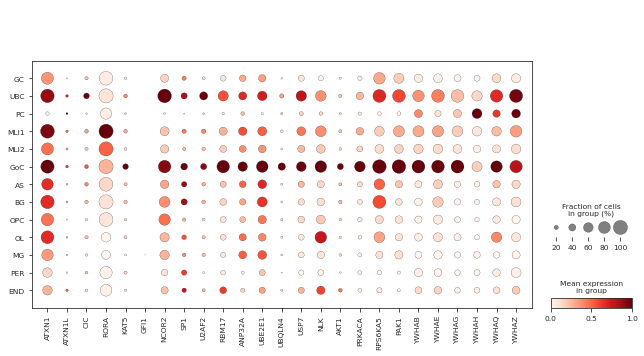

In [15]:
sc.pl.dotplot(adata, genes, groupby='sub4', standard_scale='var', use_raw=True, save = 'ATXN1_interactor_Ctrl_dotplot.pdf')

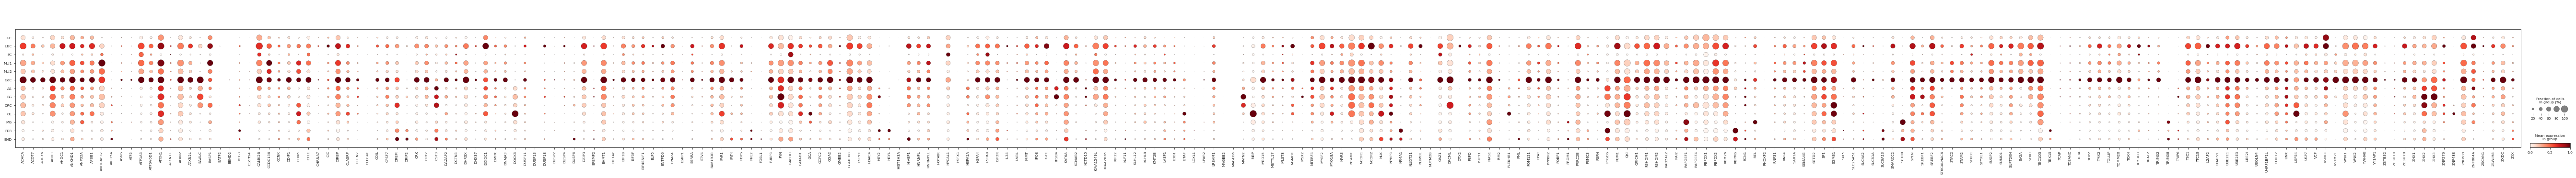

In [16]:
sc.pl.dotplot(adata, retained_interactors, groupby='sub4', standard_scale='var', use_raw=True)

### Imputed data

In [17]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='230502_Ctrl_imp.h5ad' # for full, can maybe get away with ~300G
    %memit adata = sc.read_h5ad(os.path.join(pdfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))

peak memory: 49865.50 MiB, increment: 42898.52 MiB
loaded @230512.12:07:42
took 39.49-s to load data


In [18]:
##Original - use for UMAP

cmap_sub4={'GC': '#FAC18A',
            'UBC': '#BA61BA',
            'PC': '#EE5264',
            'MLI1': '#F9EBAE',
            'MLI2': '#88BB92',
            'GoC': '#46A928',
            'AS': '#F9AEAE',
            'BG': '#AEB7F9',
            'OPC': '#F1815F',
            'OL': '#75A3B7',
            'MG': '#AC5861',
            'PER': '#2D284B',
            'END': '#1C67EE'}
cmap_genotype={'Ctrl':'#010101',
               'SCA1':'#ffd478'}

adata.uns['sub4_colors']=np.array(list(cmap_sub4.values()),dtype=object)
adata.obs['sub4'].cat.reorder_categories(new_categories=list(cmap_sub4.keys()),
                                         inplace=True,ordered=True)

In [19]:
interactors = []
with open(os.path.join(pfp,'ataxin-1 interactors human.csv')) as f:
    for line in f:
        gene = line.rstrip()
       # gene = gene[0] + gene[1:].lower()
        interactors.append(gene)
f.close()

In [20]:
retained_interactors = [i for i in interactors if i in adata.var.index.to_list()]
missing_interactors = [i for i in interactors if i not in adata.var.index.to_list()]
print('These interactors were not in the data:')
for i in range(0, len(missing_interactors) - 4, 4):
    print('  {}, {}, {}, {}, '.format(missing_interactors[i], missing_interactors[i+1], missing_interactors[i+2], missing_interactors[i+3]))

# create dataframe
X = pd.DataFrame({'ctype':adata.obs['sub4'],
                  'gtype':adata.obs['genotype']})


x = pd.DataFrame(np.asarray(adata[:, retained_interactors].layers['imputed']),
                 columns=adata[:, retained_interactors].var_names,
                 index=adata.obs.index)

X = pd.merge(X,x, left_index=True,right_index=True)
del x

These interactors were not in the data:
  C2orf27B, FAM21C, FAM46A, FAM46B, 
  HYPM, KIAA1429, LOC401442, MAGEB18, 


In [21]:
x = X
x = x.set_index(['ctype','gtype'])
x[x.columns] = zscore(x,axis=0)
x = x.reset_index()
x = x.groupby(['ctype','gtype']).mean()
x = x.reset_index()
# x = x.set_index(['/ctype','gtype'])
x['ctype_colors'] = x['ctype'].map(cmap_sub4)
x['gtype_colors'] = x['gtype'].map(cmap_genotype)

x.to_csv('/home/cl2292/project/SCA1_snRNAseq/Human/results_20230402/ATXN1_interactor_z_score_by_ctype_CTRL_imp.csv')

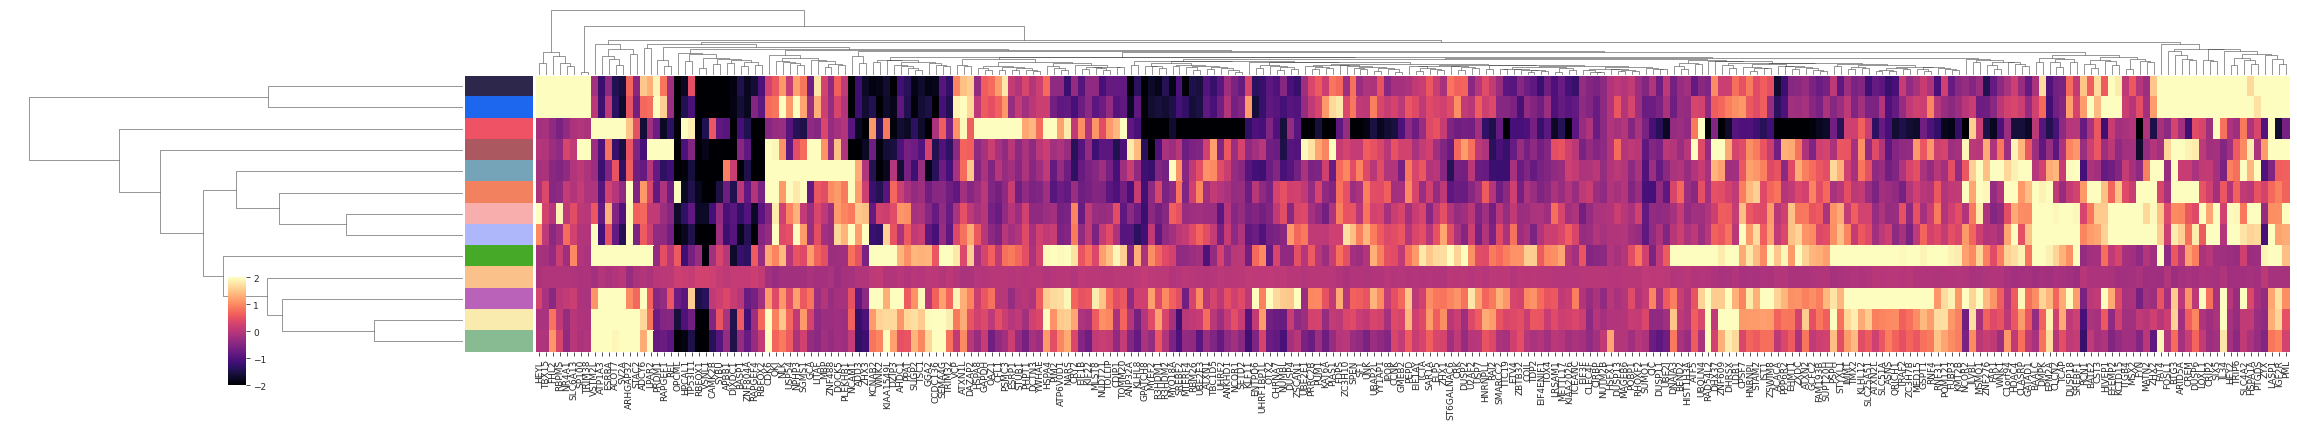

In [22]:
# plot

x = x.drop(columns=['HOTAIR','MAGEB2'])
x_condition = x.loc[x['gtype']=='Ctrl']
cols = [i for i in x.columns if i not in ['ctype','gtype','gtype_colors','ctype_colors']]
p = sns.clustermap(x_condition[cols], 
                   cmap='magma',
                   col_cluster=True,
                   row_cluster=True,
                   row_colors=[x_condition['ctype_colors']],
                   xticklabels=True,
                   yticklabels=False,
                   vmin=-2,vmax=2,
                   figsize=(32,6))
p.cax.set_position([0.1, 0.1, .008, .25])
p.savefig(os.path.join(pfp,'ATXN1_interactor_z_score_by_ctype_CTRL_heatmap_imp.pdf'),bbox_inches='tight')